# Experiment 3: Neural Networks

21th April 2024

## Description

In this experiment, you will implement neural networks on CIFAR-10, and deepen the knowledge and understanding of the networks through multiple tricks.

Write your code between the lines `########## Start/End of Your Code ##########`.

You should add some comments to keep readability of your code. If your code is not understandable, you will not receive full marks even if your results are correct.

You can add some markdown/code cells to explain your code if necessary.


In [2]:
# Import necessary libraries
# If you have not installed the libraries, you can install them first
# You can add more libraries if necessary

import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim
from sklearn import metrics
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import numpy as np

# set seed
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)



## Task 1: Implement Your First Neural Network

In this task, you are required to implement a simple Convolutional Neural Network (CNN) for CIFAR-10 classification.

In [3]:
# Some hyperparameters
batch_size = 32
learning_rate = 0.01
momentum = 0.9
epoch_num = 10
default_transform = transforms.Compose([transforms.ToTensor()])
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data Loading

Load CIFAR-10 dataset. CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. You can refer to the [page](https://www.cs.toronto.edu/~kriz/cifar.html) for more information about the dataset.

In [4]:
# Load CIFAR-10 dataset

train_set = datasets.CIFAR10(root='../../data', train=True, download=True, transform=default_transform)  # Change the root directory to store the dataset
test_set = datasets.CIFAR10(root='../../data', train=False, download=True, transform=default_transform)  # The dataset will be downloaded automatically

print(f"Number of training examples: {len(train_set)}")
print(f"Number of test examples: {len(test_set)}")
print(f"Image Shape: {train_set[0][0].shape}")
print(f"Number of classes: {len(train_set.classes)}")

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 46278215.40it/s]


Extracting ../../data/cifar-10-python.tar.gz to ../../data
Files already downloaded and verified
Number of training examples: 50000
Number of test examples: 10000
Image Shape: torch.Size([3, 32, 32])
Number of classes: 10


### Implementation

Implement a simple CNN model for CIFAR-10 classification. Your model should have the following architecture:

| Layers | Hyper-parameters                                                              |
|--------|-------------------------------------------------------------------------------|
| conv_1 | in_channel=3, out_channel=16, kernel_size=(5, 5), stride=1, followed by ReLU  |
| pool_1 | kernel_size=(2, 2), stride=2                                                  |
| conv_2 | in_channel=16, out_channel=36, kernel_size=(3, 3), stride=1, followed by ReLU |
| pool_2 | kernel=(2, 2), stride=2                                                       |
| fc_1   | (1296, 128), followed by ReLU                                                 |
| fc_2   | (128, 10), followed by ReLU                                                   |

This simple CNN model contains two convolutional layers and two max pooling layers. Do not forget to flatten the output tensor before feeding it to the final fully connected layers.

In [5]:
# Define your CNN model

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=36, kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1296, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self,x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 36 * 6 * 6)  # Flatten
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return x

### Training

Train your model on CIFAR-10 training set. We use simple stochastic gradient descent (SGD) as the optimizer and cross-entropy loss as the loss function.

If you find training extremely slow, you can reduce the number of epochs or the size of the dataset. This can be due to the limited computational resources provided by your personal computer. You can also use Google Colab to run your code on a GPU.

In [11]:
# Initialize your model
my_net = MyNet().to(device)
print(my_net)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net.parameters(), lr=learning_rate, momentum=momentum)

MyNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 36, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1296, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [12]:
# Training
losses = []
for epoch in range(epoch_num):
    running_loss = []
    for i, data in enumerate(train_loader, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()  # Remember to zero the gradients every iteration

        outputs = my_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        running_loss.append(loss.item())
        if i % 100 == 99:
            print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {sum(running_loss) / len(running_loss):.3f}")
            losses.append(sum(running_loss) / len(running_loss))
            running_loss = []

Epoch: 1, Batch: 100, Loss: 2.295
Epoch: 1, Batch: 200, Loss: 2.186
Epoch: 1, Batch: 300, Loss: 2.086
Epoch: 1, Batch: 400, Loss: 1.958
Epoch: 1, Batch: 500, Loss: 1.900
Epoch: 1, Batch: 600, Loss: 1.816
Epoch: 1, Batch: 700, Loss: 1.755
Epoch: 1, Batch: 800, Loss: 1.705
Epoch: 1, Batch: 900, Loss: 1.643
Epoch: 1, Batch: 1000, Loss: 1.547
Epoch: 1, Batch: 1100, Loss: 1.523
Epoch: 1, Batch: 1200, Loss: 1.513
Epoch: 1, Batch: 1300, Loss: 1.511
Epoch: 1, Batch: 1400, Loss: 1.478
Epoch: 1, Batch: 1500, Loss: 1.426
Epoch: 2, Batch: 100, Loss: 1.351
Epoch: 2, Batch: 200, Loss: 1.340
Epoch: 2, Batch: 300, Loss: 1.312
Epoch: 2, Batch: 400, Loss: 1.309
Epoch: 2, Batch: 500, Loss: 1.326
Epoch: 2, Batch: 600, Loss: 1.300
Epoch: 2, Batch: 700, Loss: 1.294
Epoch: 2, Batch: 800, Loss: 1.283
Epoch: 2, Batch: 900, Loss: 1.311
Epoch: 2, Batch: 1000, Loss: 1.250
Epoch: 2, Batch: 1100, Loss: 1.195
Epoch: 2, Batch: 1200, Loss: 1.221
Epoch: 2, Batch: 1300, Loss: 1.219
Epoch: 2, Batch: 1400, Loss: 1.235
Epo

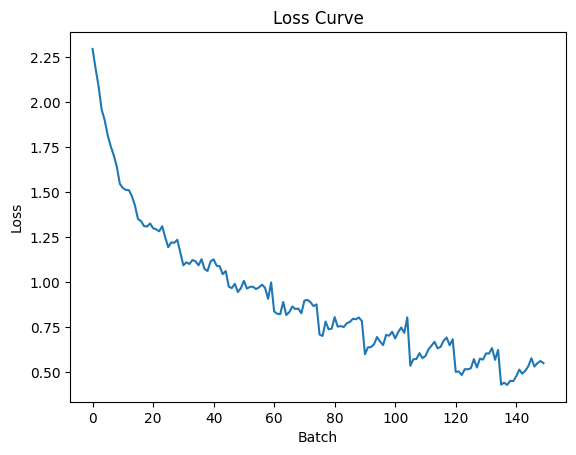

In [13]:
# Observe the loss curve
figure, ax = plt.subplots()
ax.plot(losses)
ax.set(xlabel='Batch', ylabel='Loss', title='Loss Curve')
plt.show()

### Testing

Test your model on CIFAR-10 test set.

In [14]:
# Testing
predictions = []
ground_truths = []
with torch.no_grad():
    for data in tqdm(test_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = my_net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        ground_truths.extend(labels.cpu().numpy())

accuracy = metrics.accuracy_score(ground_truths, predictions)
print(f"Accuracy: {accuracy:.3f}")

100%|██████████| 313/313 [00:01<00:00, 198.05it/s]

Accuracy: 0.636


## Task 2: Implement Neural Network with Data Augmentation

In this task, you are required to implement a CNN for CIFAR-10 classification with data augmentation. Data augmentation is a technique to artificially create new training data from the existing training data. It can help improve the performance of the model and reduce overfitting.

In [7]:
# set seed
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Load CIFAR-10 dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),              # 转换成Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = datasets.CIFAR10(root='../../data', train=True, download=True, transform=train_transform)  # Change the root directory to store the dataset
test_set = datasets.CIFAR10(root='../../data', train=False, download=True, transform=test_transform)  # The dataset will be downloaded automatically

print(f"Number of training examples: {len(train_set)}")
print(f"Number of test examples: {len(test_set)}")
print(f"Image Shape: {train_set[0][0].shape}")
print(f"Number of classes: {len(train_set.classes)}")

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 50000
Number of test examples: 10000
Image Shape: torch.Size([3, 32, 32])
Number of classes: 10


### Training

Train your model on CIFAR-10 training set. We use simple stochastic gradient descent (SGD) as the optimizer and cross-entropy loss as the loss function.

In [8]:
my_net_aug = MyNet().to(device)
print(my_net_aug)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net_aug.parameters(), lr=learning_rate, momentum=momentum)

MyNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 36, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1296, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [9]:
# Training
losses = []
for epoch in range(epoch_num):
    running_loss = []
    for i, data in enumerate(train_loader, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()  # Remember to zero the gradients every iteration

        outputs = my_net_aug(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        running_loss.append(loss.item())
        if i % 100 == 99:
            print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {sum(running_loss) / len(running_loss):.3f}")
            losses.append(sum(running_loss) / len(running_loss))
            running_loss = []

Epoch: 1, Batch: 100, Loss: 2.265
Epoch: 1, Batch: 200, Loss: 2.098
Epoch: 1, Batch: 300, Loss: 1.943
Epoch: 1, Batch: 400, Loss: 1.819
Epoch: 1, Batch: 500, Loss: 1.729
Epoch: 1, Batch: 600, Loss: 1.676
Epoch: 1, Batch: 700, Loss: 1.636
Epoch: 1, Batch: 800, Loss: 1.554
Epoch: 1, Batch: 900, Loss: 1.564
Epoch: 1, Batch: 1000, Loss: 1.536
Epoch: 1, Batch: 1100, Loss: 1.514
Epoch: 1, Batch: 1200, Loss: 1.493
Epoch: 1, Batch: 1300, Loss: 1.514
Epoch: 1, Batch: 1400, Loss: 1.461
Epoch: 1, Batch: 1500, Loss: 1.413
Epoch: 2, Batch: 100, Loss: 1.407
Epoch: 2, Batch: 200, Loss: 1.383
Epoch: 2, Batch: 300, Loss: 1.351
Epoch: 2, Batch: 400, Loss: 1.349
Epoch: 2, Batch: 500, Loss: 1.345
Epoch: 2, Batch: 600, Loss: 1.337
Epoch: 2, Batch: 700, Loss: 1.329
Epoch: 2, Batch: 800, Loss: 1.285
Epoch: 2, Batch: 900, Loss: 1.279
Epoch: 2, Batch: 1000, Loss: 1.290
Epoch: 2, Batch: 1100, Loss: 1.274
Epoch: 2, Batch: 1200, Loss: 1.294
Epoch: 2, Batch: 1300, Loss: 1.257
Epoch: 2, Batch: 1400, Loss: 1.277
Epo

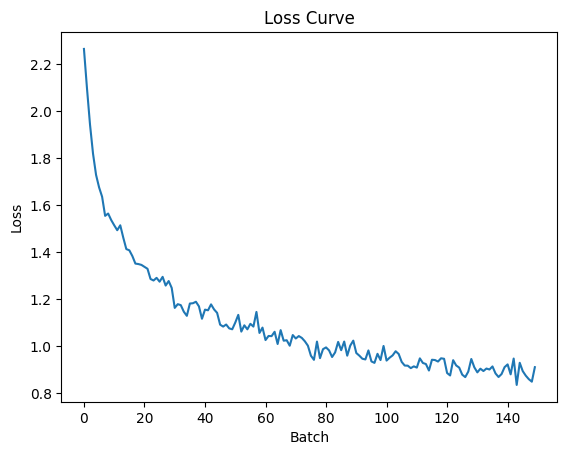

In [10]:
# Observe the loss curve
figure, ax = plt.subplots()
ax.plot(losses)
ax.set(xlabel='Batch', ylabel='Loss', title='Loss Curve')
plt.show()

### Testing

Test your model on CIFAR-10 test set.

In [12]:
# Testing
predictions = []
ground_truths = []
with torch.no_grad():
    for data in tqdm(test_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = my_net_aug(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        ground_truths.extend(labels.cpu().numpy())

accuracy = metrics.accuracy_score(ground_truths, predictions)
print(f"Accuracy: {accuracy:.3f}")

100%|██████████| 313/313 [00:04<00:00, 74.98it/s] 

Accuracy: 0.660


## Task 3: Modify the Architecture of the Neural Network
In this task, you are required to implement a CNN for CIFAR-10 classification with dropout. Dropout is a technique to randomly omit some feature detectors on each training case. It can help improve the performance of the model and reduce overfitting.

In [13]:
# set seed
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Load CIFAR-10 dataset

train_set = datasets.CIFAR10(root='../../data', train=True, download=True, transform=default_transform)  # Change the root directory to store the dataset
test_set = datasets.CIFAR10(root='../../data', train=False, download=True, transform=default_transform)  # The dataset will be downloaded automatically

print(f"Number of training examples: {len(train_set)}")
print(f"Number of test examples: {len(test_set)}")
print(f"Image Shape: {train_set[0][0].shape}")
print(f"Number of classes: {len(train_set.classes)}")

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 50000
Number of test examples: 10000
Image Shape: torch.Size([3, 32, 32])
Number of classes: 10


In [14]:
# Define your CNN model
class MyNet_drop(nn.Module):
    def __init__(self):
        super(MyNet_drop, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=36, kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1296, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.1)

    def forward(self,x):
        x = self.dropout(self.pool1(F.relu(self.conv1(x))))
        x = self.dropout(self.pool2(F.relu(self.conv2(x))))
        x = x.view(-1, 36 * 6 * 6)  # Flatten
        x = F.relu(self.fc2(self.dropout(F.relu(self.fc1(x)))))
        return x

In [15]:
# Initialize your model
my_net_drop = MyNet_drop().to(device)
print(my_net_drop)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net_drop.parameters(), lr=learning_rate, momentum=momentum)

MyNet_drop(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 36, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1296, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


### Training

Train your model on CIFAR-10 training set. We use simple stochastic gradient descent (SGD) as the optimizer and cross-entropy loss as the loss function.

In [16]:
# Training

losses = []
for epoch in range(epoch_num):
    running_loss = []
    for i, data in enumerate(train_loader, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()  # Remember to zero the gradients every iteration

        outputs = my_net_drop(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        running_loss.append(loss.item())
        if i % 100 == 99:
            print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {sum(running_loss) / len(running_loss):.3f}")
            losses.append(sum(running_loss) / len(running_loss))
            running_loss = []

Epoch: 1, Batch: 100, Loss: 2.296
Epoch: 1, Batch: 200, Loss: 2.197
Epoch: 1, Batch: 300, Loss: 2.087
Epoch: 1, Batch: 400, Loss: 1.983
Epoch: 1, Batch: 500, Loss: 1.937
Epoch: 1, Batch: 600, Loss: 1.881
Epoch: 1, Batch: 700, Loss: 1.806
Epoch: 1, Batch: 800, Loss: 1.775
Epoch: 1, Batch: 900, Loss: 1.717
Epoch: 1, Batch: 1000, Loss: 1.682
Epoch: 1, Batch: 1100, Loss: 1.640
Epoch: 1, Batch: 1200, Loss: 1.605
Epoch: 1, Batch: 1300, Loss: 1.540
Epoch: 1, Batch: 1400, Loss: 1.538
Epoch: 1, Batch: 1500, Loss: 1.499
Epoch: 2, Batch: 100, Loss: 1.440
Epoch: 2, Batch: 200, Loss: 1.413
Epoch: 2, Batch: 300, Loss: 1.380
Epoch: 2, Batch: 400, Loss: 1.383
Epoch: 2, Batch: 500, Loss: 1.384
Epoch: 2, Batch: 600, Loss: 1.361
Epoch: 2, Batch: 700, Loss: 1.375
Epoch: 2, Batch: 800, Loss: 1.352
Epoch: 2, Batch: 900, Loss: 1.355
Epoch: 2, Batch: 1000, Loss: 1.330
Epoch: 2, Batch: 1100, Loss: 1.282
Epoch: 2, Batch: 1200, Loss: 1.319
Epoch: 2, Batch: 1300, Loss: 1.290
Epoch: 2, Batch: 1400, Loss: 1.320
Epo

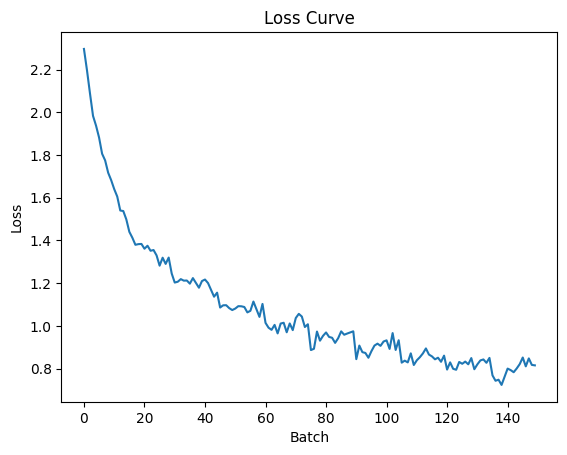

In [17]:
# Observe the loss curve
figure, ax = plt.subplots()
ax.plot(losses)
ax.set(xlabel='Batch', ylabel='Loss', title='Loss Curve')
plt.show()

### Testing

Test your model on CIFAR-10 test set.

In [18]:
# Testing
predictions = []
ground_truths = []
with torch.no_grad():
    for data in tqdm(test_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = my_net_drop(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        ground_truths.extend(labels.cpu().numpy())

accuracy = metrics.accuracy_score(ground_truths, predictions)
print(f"Accuracy: {accuracy:.3f}")

100%|██████████| 313/313 [00:02<00:00, 139.61it/s]


Accuracy: 0.646


## Task 4: Try Different Loss Functions on Long-Tailed Dataset

Real-world classiﬁcation problems typically exhibit an imbalanced or long-tailed label dis-
tribution, wherein many labels are associated with only a few samples. This poses a challenge
for generalisation on such labels, and also makes naïve learning biased towards dominant labels.

LA[1] once proposed a loss function to solve the long tail problem, which is still considered the most effective method. For the sake of simplicity, we have omitted the theoretical derivation formula for everyone, and only give the final conclusion here. Please implement it by yourself based on the loss function given.The LA formula is as follows:

$$\ell(y, f(x))=-\log \frac{e^{f_{y}(x)+\tau \cdot \log \pi_{y}}}{\sum_{y^{\prime} \in[L]} e^{f_{y^{\prime}}(x)+\tau \cdot \log \pi_{y^{\prime}}}}$$

where $f(x)$ is the logit of the model output, $y$ is the label corresponding to the sample, $\tau$ is the prior probability of the class, and is usually set to 1.

[1]Menon, A. K., Jayasumana, S., Rawat, A. S., Jain, H., Veit, A., & Kumar, S. (2020). Long-tail learning via logit adjustment. arxiv preprint arxiv:2007.07314. https://github.com/google-research/google-research/tree/master/logit_adjustment


In order to reduce the pressure on students, we will directly extract the code of the data set with an imbalance rate of 100 from CIFAR10 and give it to you. Note that you do not need to modify the code of the next module, but you must understand the meaning of the function name, because in the subsequent code implementation, especially when implementing LA loss functiond, calling the appropriate function will be of great help to you.

In [19]:
class IMBALANCECIFAR10(datasets.CIFAR10):
    cls_num = 10

    def __init__(self, root, imb_factor=None, rand_number=0, train=True,
                 transform=None, target_transform=None, download=True):
        super().__init__(root, train, transform, target_transform, download)

        if train and imb_factor is not None:
            np.random.seed(rand_number)
            img_num_list = self.get_img_num_per_cls(self.cls_num, imb_factor)
            self.gen_imbalanced_data(img_num_list)

        self.classnames = self.classes
        self.labels = self.targets
        self.cls_num_list = self.get_cls_num_list()
        self.num_classes = len(self.cls_num_list)

    def get_img_num_per_cls(self, cls_num, imb_factor):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        for cls_idx in range(cls_num):
            num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
            img_num_per_cls.append(int(num))
        return img_num_per_cls

    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        targets_np = np.array(self.targets, dtype=np.int64)
        classes = np.unique(targets_np)
        # np.random.shuffle(classes)
        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets

    def get_cls_num_list(self):
        counter = defaultdict(int)
        for label in self.labels:
            counter[label] += 1
        labels = list(counter.keys())
        labels.sort()
        cls_num_list = [counter[label] for label in labels]
        return cls_num_list

class CIFAR10_IR100(IMBALANCECIFAR10):
    def __init__(self, root, train=True, transform=None):
        super().__init__(root, imb_factor=0.01, train=train, transform=transform)

Use the function defined above, load CIFAR10_IR100 as the training set, and load the test set in Task1 as the test set (both need to use the CIFAR10_IR100 function)，

In [20]:
# set seed
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

train_set = CIFAR10_IR100(root='../../data', train=True, transform=default_transform)  # Change the root directory to store the dataset
test_set = CIFAR10_IR100(root='../../data', train=False, transform=default_transform)  # The dataset will be downloaded automatically

print(f"Number of training examples: {len(train_set)}")
print(f"Number of test examples: {len(test_set)}")
print(f"Image Shape: {train_set[0][0].shape}")
print(f"Number of classes: {len(train_set.classes)}")

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 12406
Number of test examples: 10000
Image Shape: torch.Size([3, 32, 32])
Number of classes: 10


### Training

Train your model on CIFAR10_IR100 training set. We use simple stochastic gradient descent (SGD) as the optimizer and cross-entropy loss as the loss function.

If you find training extremely slow, you can reduce the number of epochs or the size of the dataset. This can be due to the limited computational resources provided by your personal computer. You can also use Google Colab to run your code on a GPU.

Note: The loss is a CE-like form, and you can implement the LA loss through modifing the output without redefining the loss function.

In [21]:
my_net = MyNet().to(device)
print(my_net)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net.parameters(), lr=learning_rate, momentum=momentum)

MyNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 36, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1296, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [22]:
cls_num_list = train_set.cls_num_list
cls_num_list = torch.tensor(cls_num_list).to(device)
cls_num_ratio = cls_num_list / torch.sum(cls_num_list)
log_cls_num = torch.log(cls_num_ratio)
tau = 2

losses = []
for epoch in range(epoch_num):
    running_loss = []
    for i, data in enumerate(train_loader, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()  # Remember to zero the gradients every iteration

        outputs = my_net(inputs)

        outputs = outputs + tau * log_cls_num.unsqueeze(0)

        loss = criterion(outputs, labels)
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        running_loss.append(loss.item())
        if i % 100 == 99:
            print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {sum(running_loss) / len(running_loss):.3f}")
            losses.append(sum(running_loss) / len(running_loss))
            running_loss = []

Epoch: 1, Batch: 100, Loss: 1.836
Epoch: 1, Batch: 200, Loss: 1.745
Epoch: 1, Batch: 300, Loss: 1.711
Epoch: 2, Batch: 100, Loss: 1.460
Epoch: 2, Batch: 200, Loss: 1.367
Epoch: 2, Batch: 300, Loss: 1.367
Epoch: 3, Batch: 100, Loss: 1.264
Epoch: 3, Batch: 200, Loss: 1.289
Epoch: 3, Batch: 300, Loss: 1.189
Epoch: 4, Batch: 100, Loss: 1.140
Epoch: 4, Batch: 200, Loss: 1.186
Epoch: 4, Batch: 300, Loss: 1.172
Epoch: 5, Batch: 100, Loss: 1.085
Epoch: 5, Batch: 200, Loss: 1.137
Epoch: 5, Batch: 300, Loss: 1.092
Epoch: 6, Batch: 100, Loss: 0.882
Epoch: 6, Batch: 200, Loss: 0.829
Epoch: 6, Batch: 300, Loss: 0.884
Epoch: 7, Batch: 100, Loss: 0.774
Epoch: 7, Batch: 200, Loss: 0.773
Epoch: 7, Batch: 300, Loss: 0.743
Epoch: 8, Batch: 100, Loss: 0.679
Epoch: 8, Batch: 200, Loss: 0.708
Epoch: 8, Batch: 300, Loss: 0.709
Epoch: 9, Batch: 100, Loss: 0.607
Epoch: 9, Batch: 200, Loss: 0.631
Epoch: 9, Batch: 300, Loss: 0.637
Epoch: 10, Batch: 100, Loss: 0.529
Epoch: 10, Batch: 200, Loss: 0.550
Epoch: 10, B

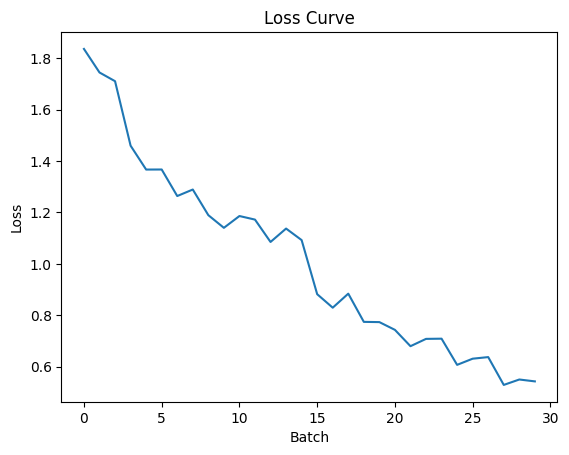

In [23]:
# Observe the loss curve
figure, ax = plt.subplots()
ax.plot(losses)
ax.set(xlabel='Batch', ylabel='Loss', title='Loss Curve')
plt.show()

### Testing

Test your model on CIFAR-10 test set.

In [24]:
# Testing
predictions = []
ground_truths = []
with torch.no_grad():
    for data in tqdm(test_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = my_net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        ground_truths.extend(labels.cpu().numpy())

accuracy = metrics.accuracy_score(ground_truths, predictions)
print(f"Accuracy: {accuracy:.3f}")

100%|██████████| 313/313 [00:01<00:00, 191.60it/s]

Accuracy: 0.443
